In [2]:
from modules import  StandardNetwork, ConvNet, TripletNetwork
from loss import SoftmaxLoss, AngularSoftmaxLoss, TripletLoss, OnlineTripletLoss
from data_modules import MNISTModule
import numpy as np
import torch
import pytorch_lightning as pl

from utils import get_embeddings, evaluate
from matplotlib import pyplot as plt

D = 2 # Embedding size
no_classes = 5 # Number of classes from MNIST

# Basic softmax

In [3]:
pl.seed_everything(3)
data = MNISTModule(data_dir='.', P=no_classes, batch_size=256)
model = StandardNetwork(ConvNet(D=D), SoftmaxLoss(D=D, C=no_classes))
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=20)
trainer.fit(model, datamodule=data)

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/t

Epoch 0:   2%|▏         | 2/120 [00:00<00:33,  3.52it/s, loss=23.5, v_num=0]

/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 19: 100%|██████████| 120/120 [00:07<00:00, 16.27it/s, loss=0.0445, v_num=0]


k-NN Accuracy on testset: 0.7332


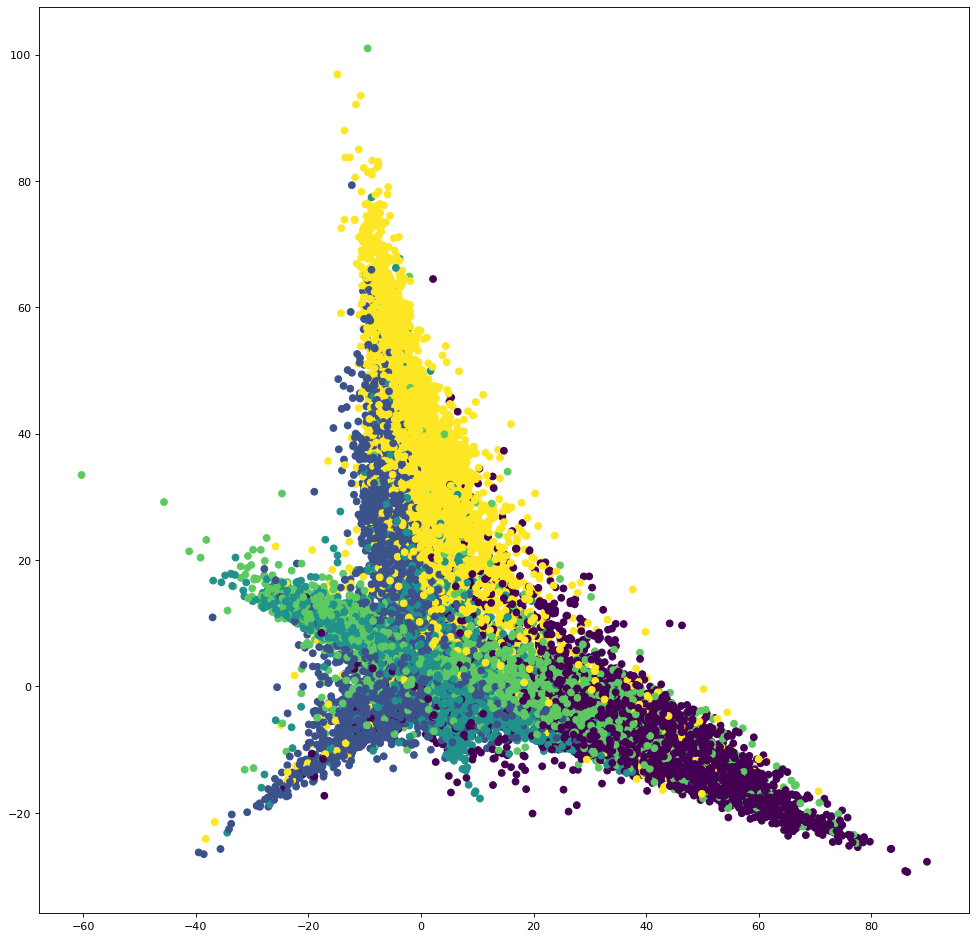

In [6]:
dl_train, dl_val = data.val_dataloader()
x_train, y_train, x_test, y_test = get_embeddings(model, dl_train, dl_val)
print(f'k-NN Accuracy on testset: {evaluate(x_train, y_train, x_test, y_test)}')

#subset = [0, 1, 2, 3, 4] # Test set of seen classes
subset = [5, 6, 7, 8, 9] # Test set of unseen classes
#subset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Whole testset
filter = np.isin(y_test.numpy(), subset)
x = x_test[filter]
t = y_test[filter]

plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(x[:, 0], x[:, 1], c=t)

# ArcFace

In [3]:
pl.seed_everything(2)
data = MNISTModule(data_dir='.', P=no_classes, batch_size=256)
model = StandardNetwork(ConvNet(D=D), AngularSoftmaxLoss(D=D, C=no_classes, s=30, m1=0.9, m2=0.4, m3=0.15))
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=20)
trainer.fit(model, datamodule=data)

Global seed set to 2
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/torch/csrc/utils/t

Epoch 0:   2%|▏         | 2/120 [00:00<00:26,  4.46it/s, loss=34.6, v_num=3]

/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448255797/work/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch 19: 100%|██████████| 120/120 [00:07<00:00, 15.88it/s, loss=0.0714, v_num=3]


k-NN Accuracy on testset: 0.7453666666666666


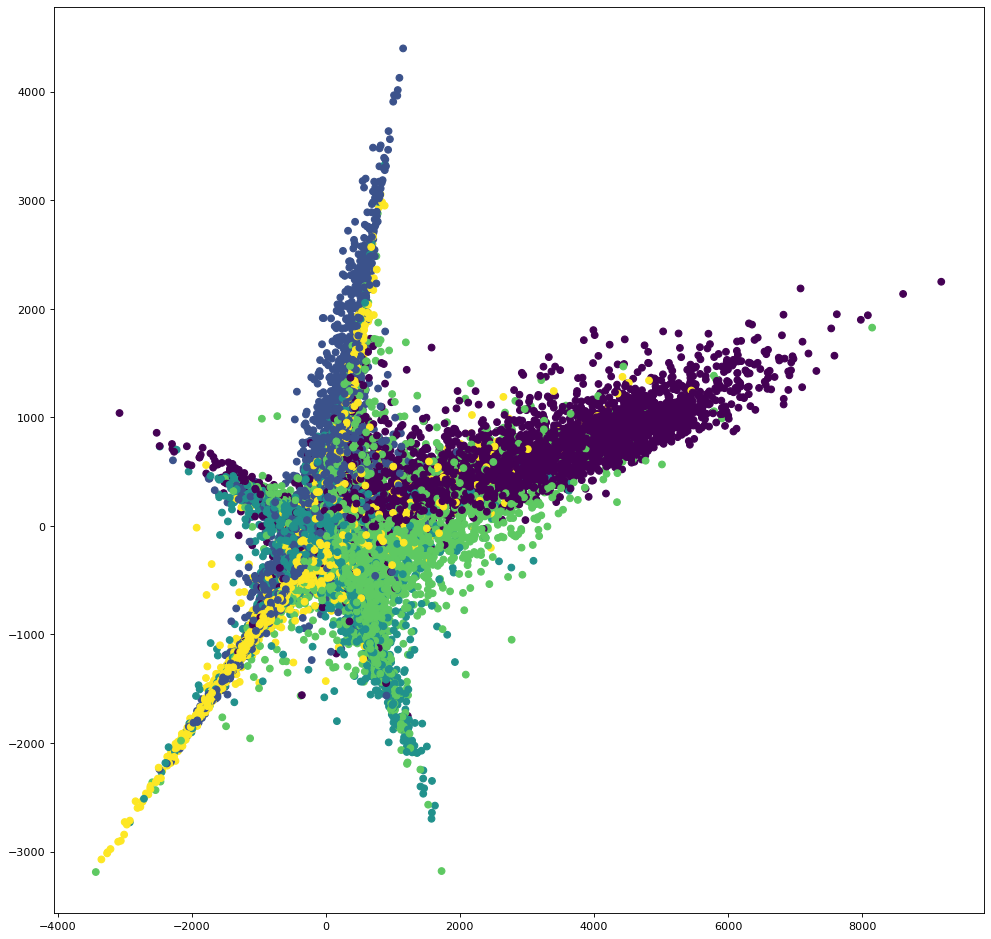

In [4]:
dl_train, dl_val = data.val_dataloader()
x_train, y_train, x_test, y_test = get_embeddings(model, dl_train, dl_val)
print(f'k-NN Accuracy on testset: {evaluate(x_train, y_train, x_test, y_test)}')

#subset = [0, 1, 2, 3, 4] # Test set of seen classes
subset = [5, 6, 7, 8, 9] # Test set of unseen classes
#subset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Whole testset
filter = np.isin(y_test.numpy(), subset)
x = x_test[filter]
t = y_test[filter]

plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(x[:, 0], x[:, 1], c=t)

# Random Triplets

In [5]:
pl.seed_everything(3)
data = MNISTModule(P=no_classes, batch_size=256, sampler='triplet')
model = TripletNetwork(ConvNet(D=D), TripletLoss(squared=True, soft=True))
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=20)
trainer.fit(model, datamodule=data)

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/vojta/anaconda3/envs/ml/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
  rank_zero_warn(f"you passed in a {loader_name} but have no {step_name}. Skipping {stage} loop")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type        | Params
-----------------------------------------
0 | backbone | ConvNet     | 1.8 M 
1 | loss     | TripletLoss | 0     
-----------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.213     Total estimated model params size (MB)


Epoch 17:   8%|▊         | 10/120 [00:02<00:24,  4.57it/s, loss=0.0158, v_num=4]

In [ ]:
dl_train, dl_val = data.val_dataloader()
x_train, y_train, x_test, y_test = get_embeddings(model, dl_train, dl_val)
print(f'k-NN Accuracy on testset: {evaluate(x_train, y_train, x_test, y_test)}')

#subset = [0, 1, 2, 3, 4] # Test set of seen classes
subset = [5, 6, 7, 8, 9] # Test set of unseen classes
#subset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Whole testset
filter = np.isin(y_test.numpy(), subset)
x = x_test[filter]
t = y_test[filter]

plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(x[:, 0], x[:, 1], c=t)

# Batch-hard Online Triplet mining
- Does not work on this data or there is bug.

In [ ]:
pl.seed_everything(3)
data = MNISTModule(P=no_classes, batch_size=64, balanced=True)
model = StandardNetwork(ConvNet(D=D), OnlineTripletLoss(squared=True, soft=True))
trainer = pl.Trainer(devices=1, accelerator="gpu", max_epochs=20)
trainer.fit(model, datamodule=data)

Global seed set to 3
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type              | Params
-----------------------------------------------
0 | backbone | ConvNet           | 1.8 M 
1 | loss     | OnlineTripletLoss | 0     
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.232     Total estimated model params size (MB)


Epoch 1: : 680it [00:17, 39.70it/s, loss=1.31, v_num=135]

In [ ]:
dl_train, dl_val = data.val_dataloader()
x_train, y_train, x_test, y_test = get_embeddings(model, dl_train, dl_val)
print(f'k-NN Accuracy on testset: {evaluate(x_train, y_train, x_test, y_test)}')

#subset = [0, 1, 2, 3, 4] # Test set of seen classes
subset = [5, 6, 7, 8, 9] # Test set of unseen classes
#subset = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Whole testset
filter = np.isin(y_test.numpy(), subset)
x = x_test[filter]
t = y_test[filter]

plt.figure(figsize=(15, 15), dpi=80)
plt.scatter(x[:, 0], x[:, 1], c=t)